<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-loading" data-toc-modified-id="Data-loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data loading</a></span><ul class="toc-item"><li><span><a href="#Tropopause-loading" data-toc-modified-id="Tropopause-loading-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tropopause loading</a></span></li><li><span><a href="#Anomalies" data-toc-modified-id="Anomalies-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Anomalies</a></span></li><li><span><a href="#EPFD-significance" data-toc-modified-id="EPFD-significance-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>EPFD significance</a></span></li></ul></li><li><span><a href="#Figure-1" data-toc-modified-id="Figure-1-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 1</a></span></li></ul></div>

In [2]:
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import shapely.geometry as sgeom

%matplotlib inline

In [4]:
%reload_ext watermark
%watermark --iversions -v -m

xarray     0.16.2
numpy      1.17.3
matplotlib 3.1.2
CPython 3.6.9
IPython 7.1.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-122-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [6]:
timescale = 20
DJF_bool = '_DJFonly'
cesta = '/mnt/4data/CMAM/0A.daily/composites_woSSW{}/'.format(DJF_bool)

# Data loading

## Tropopause loading

In [7]:
infile_name = '{}{}_{}_comp_*_{}days.nc'.format(cesta, 'ptrop', 'absolute', 20)
infiles = glob.glob(infile_name)
e_types = list(map(lambda x: x.split('comp_')[1].split('_{}days'.format(timescale))[0], infiles))
da_trop =  xr.open_mfdataset(infiles, concat_dim='e_type', combine = 'nested')
da_trop['e_type'] = e_types
da_trop['ptrop'] = da_trop.ptrop/100.
da_trop

<xarray.Dataset>
Dimensions:  (e_type: 3, lag: 21, lat: 48, lon: 96)
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * lag      (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10
  * e_type   (e_type) <U9 'himalayas' 'westamer' 'eastasia'
Data variables:
    ptrop    (e_type, lag, lat, lon) float64 dask.array<chunksize=(1, 21, 48, 96), meta=np.ndarray>

## Anomalies 

In [8]:
timescale = 20
num_waves = 3
wave_range = list(range(1,num_waves+1))#+['45678']
e_type_ls = ['himalayas', 'eastasia', 'westamer']
titles = ['Himalayas', 'East Asia', 'Rocky Mountains'] #'West America']
var_ls= ['acceldiv-calc','ep_p','ep_phi','acceldiv-calc_wn','ep_phi-wn','ep_p-wn','accelogw']#, 'accelogw'] #'ua'
what = 'anomalies'
inserted_wave = 0#'all'

ds_ls = []
for var in var_ls:
    da_ls = []
    for i,e_type in enumerate(e_type_ls):
        if var == 'accelogw':
            infile = f'{cesta}{var}_{what}_comp_{e_type}_{timescale}days.nc'
            print(infile)
            da_wave = xr.open_dataarray(infile)
            da_wave['plev'] = da_wave.plev/100.
            da_wave['plev'].attrs['units'] = 'hPa'
            #print(da)
        elif var == 'ep_p':
            infile = f'{cesta}{var}_{what}_comp_{e_type}_{timescale}days.nc'
            print(infile)
            da_wave = xr.open_dataarray(infile)
            da_wave = da_wave.expand_dims('wave')
            da_wave.name = var+'-wn1'
            da_wave['wave'] = [inserted_wave]#'all']
            
        elif var == 'ep_phi':
            infile = f'{cesta}{var}_{what}_comp_{e_type}_{timescale}days.nc'
            print(infile)
            da_wave = xr.open_dataarray(infile)
            da_wave = da_wave.expand_dims('wave')
            da_wave.name = var+'-wn1'
            da_wave['wave'] = [inserted_wave]#'al
        
        elif var == 'acceldiv-calc':
            infile = f'{cesta}{var}_{what}_comp_{e_type}_{timescale}days.nc'
            print(infile)
            da_wave = xr.open_dataarray(infile)
            da_wave = da_wave.expand_dims('wave')
            da_wave['plev'] = da_wave.plev/100.
            da_wave['plev'].attrs['units'] = 'hPa'
            da_wave.name = var+'_wn1'
            da_wave['wave'] = [inserted_wave]#'all']
            
        else:
            da_wave_ls = []
            for i in wave_range:
                infile = f'{cesta}{var}{i}_{what}_comp_{e_type}_{timescale}days.nc'
                print(infile)
                da = xr.open_dataarray(infile)
                #da['wave'] = ['#'+str(i)]
                #da = da.squeeze()
                da = da.reset_coords(drop=True)
                if i == '45678':
                    da = da.expand_dims('wave')
                    da['wave'] = [i]
                    
                #da['plev'] = da.plev/100.
                da_wave_ls.append(da)
                
            da_wave = xr.concat(da_wave_ls, dim = 'wave')                
            #print(da)#.data_vars.keys()[0])
        
            #print(da_wave)
        da_ls.append(da_wave)
    da_conc = xr.concat(da_ls, dim = 'e_type')
    da_conc['e_type'] = e_type_ls 
    ds_ls.append(da_conc)
    
ds_all = xr.merge(ds_ls)#, compat='override')
ds_all

/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv-calc_anomalies_comp_himalayas_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv-calc_anomalies_comp_eastasia_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv-calc_anomalies_comp_westamer_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/ep_p_anomalies_comp_himalayas_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/ep_p_anomalies_comp_eastasia_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/ep_p_anomalies_comp_westamer_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/ep_phi_anomalies_comp_himalayas_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/ep_phi_anomalies_comp_eastasia_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/ep_phi_anomalies_comp_westamer_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv-calc_wn1_anomalies_comp_himalayas_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv-c

<xarray.Dataset>
Dimensions:            (e_type: 3, lag: 21, lat: 48, lon: 96, plev: 63, wave: 4)
Coordinates:
  * wave               (wave) int64 0 1 2 3
  * plev               (plev) float64 1e+03 925.0 850.0 ... 0.0015 0.001 0.0007
  * lat                (lat) float64 -87.16 -83.48 -79.78 ... 79.78 83.48 87.16
  * lag                (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 ... 3 4 5 6 7 8 9 10
  * e_type             (e_type) <U9 'himalayas' 'eastasia' 'westamer'
  * lon                (lon) float64 0.0 3.75 7.5 11.25 ... 348.8 352.5 356.2
Data variables:
    acceldiv-calc_wn1  (e_type, wave, lag, plev, lat) float64 0.2569 ... -1.319
    ep_p-wn1           (e_type, wave, lag, plev, lat) float64 0.001124 ... 2....
    ep_phi-wn1         (e_type, wave, lag, plev, lat) float64 0.1493 ... 0.7105
    accelogw           (e_type, lag, plev, lat, lon) float64 -9.048e-16 ... 3...

## EPFD significance

In [10]:
da_pv_ls = []
for e_type in e_type_ls:
    
    da_wave_ls = []
    for i in wave_range:
        outfile_name = f'{cesta}acceldiv-calc_wn{i}_pvalues_from10000_comp_{e_type}_20days.nc'
        print(outfile_name)
        da_pv = xr.open_dataarray(outfile_name)
        #da_pv['plev'] = da_pv.plev/100.
        
        da_pv = da_pv.reset_coords(drop=True)
        if i == '45678':
            da_pv = da_pv.expand_dims('wave')
            da_pv['wave'] = [i]

        da_wave_ls.append(da_pv)
        
    outfile_name = f'{cesta}acceldiv-calc_pvalues_from10000_comp_{e_type}_20days.nc'
    print(outfile_name)
    da_pv = xr.open_dataarray(outfile_name)
    da_pv['plev'] = da_pv.plev/100.
    da_pv['plev'].attrs['units'] = 'hPa'
    da_pv = da_pv.expand_dims('wave')
    da_pv['wave'] = [0]
    da_wave_ls.append(da_pv)  
    da_pv_ls.append(xr.concat(da_wave_ls, dim = 'wave'))

da_pv_all = xr.concat(da_pv_ls, dim = 'e_type')
da_pv_all['e_type'] = e_type_ls 
da_pv_all


/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv-calc_wn1_pvalues_from10000_comp_himalayas_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv-calc_wn2_pvalues_from10000_comp_himalayas_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv-calc_wn3_pvalues_from10000_comp_himalayas_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv-calc_pvalues_from10000_comp_himalayas_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv-calc_wn1_pvalues_from10000_comp_eastasia_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv-calc_wn2_pvalues_from10000_comp_eastasia_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv-calc_wn3_pvalues_from10000_comp_eastasia_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv-calc_pvalues_from10000_comp_eastasia_20days.nc
/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/acceldiv-calc_wn1_pvalues_from10000_comp_westamer_20days.nc
/mnt/4data/CMA

<xarray.DataArray 'acceldiv-calc_wn1' (e_type: 3, wave: 4, plev: 63, lat: 48, lag: 21)>
array([[[[[3.28205588e-01, 3.27835158e-01, 3.78772455e-01, ...,
           2.80774020e-01, 3.51969063e-01, 2.85913867e-01],
          [2.02229144e-02, 2.01974400e-02, 2.05142325e-02, ...,
           2.02296275e-02, 2.03739222e-02, 1.99859107e-02],
          [1.47198396e-01, 1.50038959e-01, 1.57334155e-01, ...,
           1.42796969e-01, 1.53788635e-01, 1.22501325e-01],
          ...,
          [1.39210748e-01, 1.40276781e-01, 8.62201418e-02, ...,
           3.64611671e-02, 1.37749424e-01, 1.37459678e-01],
          [1.26402788e-01, 8.61063273e-02, 6.39535694e-03, ...,
           1.19603501e-01, 4.45767948e-02, 1.20499332e-01],
          [9.28125972e-03, 9.07980327e-03, 8.78961336e-03, ...,
           8.92283256e-03, 8.81509250e-03, 9.33044875e-03]],

         [[3.04610624e-01, 2.99432398e-01, 3.63087941e-01, ...,
           2.73985904e-01, 3.33085915e-01, 2.74558812e-01],
          [4.44588945e-02, 4.42079511e-02, 4.36872443e-02, ...,
           4.44244749e-02, 4.44904615e-02, 4.40827560e-02],
          [2.51764834e-01, 2.55235253e-01, 2.69809645e-01, ...,
           2.72502845e-01, 2.69678306e-01, 2.72647797e-01],
...
          [6.16319197e-02, 5.85641978e-02, 4.87125411e-02, ...,
           5.30823032e-02, 6.77517069e-02, 6.80833976e-02],
          [3.93911635e-02, 5.29853353e-02, 5.20552414e-02, ...,
           5.46890824e-02, 4.43694481e-02, 4.82294893e-02],
          [3.91309443e-02, 3.18375521e-02, 3.74018357e-02, ...,
           3.95285251e-02, 3.89497672e-02, 3.85149178e-02]],

         [[1.78227439e-02, 1.60989532e-02, 1.75670526e-02, ...,
           1.33505990e-02, 1.80907053e-02, 1.78412013e-02],
          [2.39900457e-02, 1.54358372e-02, 2.75923516e-02, ...,
           1.52631960e-02, 2.77968028e-02, 2.00667286e-02],
          [3.14143134e-02, 3.23052645e-02, 1.83513588e-02, ...,
           2.76710040e-02, 2.72095273e-02, 2.86168416e-02],
          ...,
          [4.27985853e-02, 4.41664069e-02, 4.19994861e-02, ...,
           4.21975952e-02, 4.33109754e-02, 4.16288736e-02],
          [3.22054566e-02, 3.59901429e-02, 3.41107879e-02, ...,
           3.61063680e-02, 3.69579906e-02, 3.62153765e-02],
          [2.37553832e-02, 2.37185817e-02, 2.14494217e-02, ...,
           2.20834851e-02, 2.33649630e-02, 2.39649506e-02]]]]])
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * plev     (plev) float64 1e+03 925.0 850.0 800.0 ... 0.0015 0.001 0.0007
  * wave     (wave) int64 1 2 3 0
  * lag      (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10
  * e_type   (e_type) <U9 'himalayas' 'eastasia' 'westamer'

In [11]:
pv_limit = 0.05 #0.05
ds_all['acceldiv-calc_wn1'] = ds_all[f'acceldiv-calc_wn1'].sel(lag = 0).where(da_pv_all.sel(lag = 0) < pv_limit)    

plev_start = 300#1000#300
plev_end = 1#50#1
lat_start = 0
ds_all_sel = ds_all.sel(lat = slice(lat_start,None), 
                         plev = slice(plev_start,plev_end))
lat = ds_all_sel.lat.values
lev = ds_all_sel.plev.values

# Figure 1

EPFD+EPfluxes+wavenumbers-0123_anomalies_all_20days_zm_wEPFDsignificancetropopause_DJFonly_pvalue005.pdf


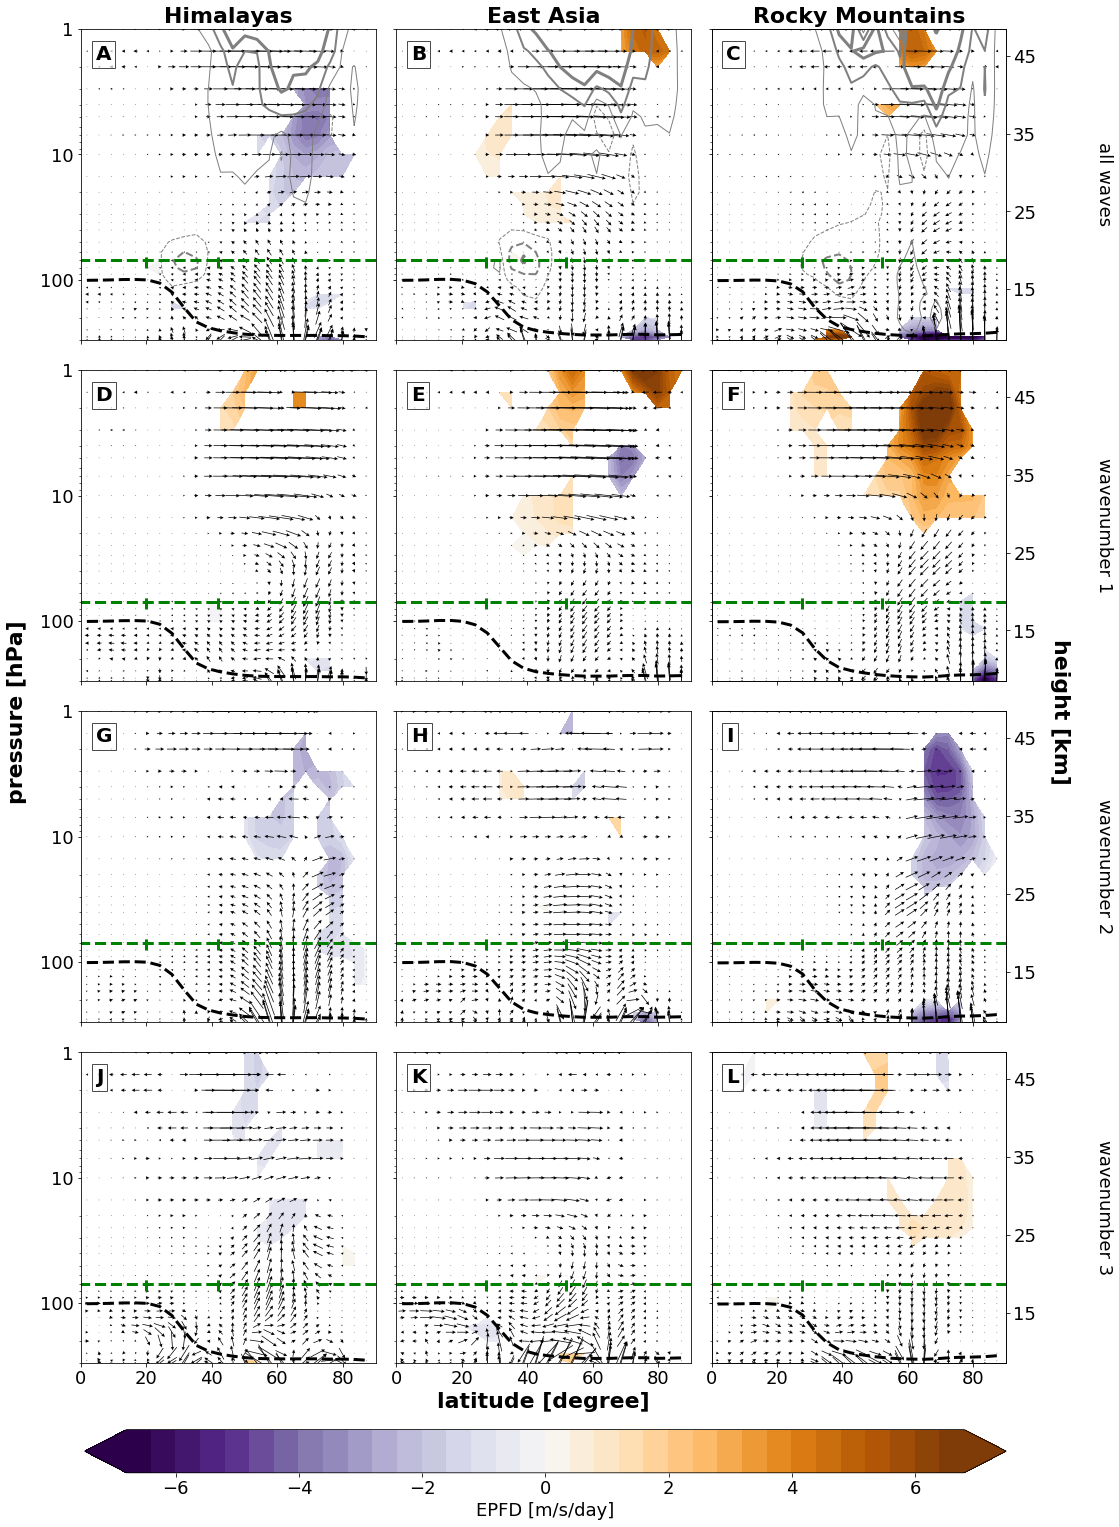

In [13]:
mpl.rcParams.update({'font.size': 18})

p = xr.plot.FacetGrid(ds_all_sel['acceldiv-calc_wn1'], col = 'e_type', row = 'wave', size = 5)

levels = np.arange(-7.2,7.6,0.4)
label_ls = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J','K','L']
row_label_ls = ['all waves', 'wavenumber 1','wavenumber 2','wavenumber 3']

cmap = mpl.cm.PuOr_r#RdBu_r
plot_kwargs = dict(yincrease = False, add_colorbar=False, cmap = cmap, levels=levels)
p.map_dataarray(xr.plot.contourf, 'lat', 'plev', **plot_kwargs)
da_trop2 = da_trop.ptrop.sel(lag=0, lat = slice(lat_start,None)).mean('lon')
j = 0
for i,(ax, sel_dict, label) in enumerate(zip(p.axes.flat, p.name_dicts.flat, label_ls)):
    if i < 3:
        plot_kwargs = dict(colors = ['gray']*3, 
                           levels = [0.1,0.5,1,3], 
                           linewidths = np.linspace(1,4,4),
                           yincrease = False)
        arr2plot = ds_all_sel['accelogw'].sel(e_type = sel_dict['e_type'],
                                    lag = 0).mean('lon')*24*3600
        arr2plot.plot.contour('lat', 'plev', ax = ax, **plot_kwargs)

        plot_kwargs['levels']=[-3,-1,-0.5,-0.1]
        plot_kwargs['linewidths'] = np.linspace(4,1,len(plot_kwargs['levels']))
        plot_kwargs['linestyles'] = 'dashed'
        arr2plot.plot.contour('lat', 'plev', ax = ax, **plot_kwargs)        
        
        
    ax.plot(lat, da_trop2.sel(e_type = sel_dict['e_type']), 'k--', lw = 3)
    ax.text(0.05, 0.95, label, transform=ax.transAxes,
              fontsize=20, fontweight='bold', va='top', bbox={'alpha': 0.7, 'facecolor': 'white'})
    sel_dict['lag'] = 0
    ax.quiver(lat, lev, ds_all_sel['ep_phi-wn1'].sel(**sel_dict).values, \
              ds_all_sel['ep_p-wn1'].sel(**sel_dict).values*-10000, pivot='mid', headwidth = 5, \
              scale_units = 'inches')
    ax.hlines(70,-20,90, color = 'green', linestyles='--', lw = 3)
    e_type = sel_dict['e_type']
    if e_type == 'himalayas':
        box = sgeom.box(minx=70, maxx=105, miny=20, maxy=42)
    elif e_type == 'eastasia':
        box = sgeom.box(minx=110, maxx=145, miny=27.5, maxy=52)
    elif e_type == 'westamer':
        box = sgeom.box(minx=-125, maxx=-102.5, miny=27.5, maxy=52)
    ax.vlines(list(box.bounds)[1::2],80,60, color = 'green', linestyles='--', lw = 3)
    if i < 3:
        ax.set_title(titles[i], fontdict = dict(fontweight = 'bold', fontsize = 22))
    ax.set_yscale('log')
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax.yaxis.set_major_formatter(fmt)
    
    
    if i in list(range(2,(num_waves+1+1)*3,3)):
        ax.annotate(row_label_ls[j],
                        color = 'white',
                        xy=(1.02, 0.5),
                        xycoords="axes fraction",
                        rotation=270,
                        ha="left",
                        va="center",
                        bbox={'alpha': 1, 'facecolor': 'white', 'edgecolor': 'w'})
        
        ax.annotate(row_label_ls[j],
                        xy=(1.3, 0.5),
                        xycoords="axes fraction",
                        rotation=270,
                        ha="left",
                        va="center",
                        bbox={'alpha': 1, 'facecolor': 'white', 'edgecolor': 'w'})
        j+=1
        
        ax2 = ax.twinx()
        ax2.get_shared_y_axes()
        ax2.axis([lat_start, 90, 7*np.log(1013.25/plev_start), 7*np.log(1013.25/plev_end)])
        ax2.tick_params(direction='out', which='both', labelsize=18)#, pad = 50)
        ax2.set_yticks([15,25,35,45])
        #ax2.set_ylabel('height [km]', fontdict = dict(fontsize = 18))
        if i == 5:
            #ax2.set_ylabel('height [km]', fontdict = dict(fontsize = 19))
            ax2.text(1.15, -0.1, 'height [km]', transform=ax.transAxes,
              fontdict = dict(fontweight = 'bold', fontsize = 22), rotation = -90, va='center')#, fontweight='bold', va='top', bbox={'alpha': 0.7, 'facecolor': 'white'})
        
        ax2.set_ylabel('')      
    
        
    if i == 3:
        ax.text(-.25, -0.1, 'pressure [hPa]', transform=ax.transAxes,
              fontdict = dict(fontweight = 'bold', fontsize = 22), rotation = 90, va = 'center')
        #ax.set_ylabel('pressure [hPa]', fontdict = dict(fontsize = 19))
    #else:
    
    ax.set_ylabel('')
        
        
   
    if i == 10:
        ax.set_xlabel('latitude [degree]', fontdict = dict(fontweight = 'bold', fontsize = 22))
    else:
        ax.set_xlabel('')

#p.row_labels
#p.set_axis_labels('')

p.fig.subplots_adjust(right=0.875)
cbar_ax = p.fig.add_axes([0.075, -0.03, .8, .03])
norm = mpl.colors.BoundaryNorm(levels[1:-1], cmap.N)
cb2 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, \
                                norm=norm, orientation='horizontal', \
                                boundaries=levels, extend='both', \
                                ticks=[-6,-4,-2,0,2,4,6], label='EPFD [m/s/day]')#, spacing='proportional')"""
                               

suffix = '_DJFonly'
outfile=f'EPFD+EPfluxes+wavenumbers-0123_{what}_all_{timescale}days_zm_wEPFDsignificancetropopause{suffix}_pvalue{str(pv_limit).replace(".","")}.pdf'
print(outfile)
plt.savefig(outfile, bbox_inches='tight')